In [3]:
!bash ex2.sh

/venv/env1/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:32<00:00, 10.80s/it]
Some weights of LlavaForConditionalGenerationScal were not initialized from the model checkpoint at llava-hf/llava-1.5-7b-hf and are newly initialized: ['language_model.model.layers.0.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.1.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.10.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.11.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.12.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.13.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.14.self_attn.rotary_emb.inv_freq', 'language_model.model.layers.15.self

In [9]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# 1. 기본 설정 및 데이터 전처리 (이전 단계와 동일)
# df는 이미 로드되어 있다고 가정합니다. (df = pd.DataFrame(json_data))
path = "output/results1.5_Controlled_Images_B_adapt_vis_research_1.0_0.9_fouroption_True.json"
with open(path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# 정답 여부 판별 함수
def check_is_correct(golden, gen):
    if not isinstance(gen, str): return False
    cond1 = (golden in gen) or (golden.lower() in gen.lower())
    cond2 = not (golden.lower() == 'on' and 'front' in gen.strip().lower())
    return cond1 and cond2

# 0.5와 1.2의 정답 여부 계산
df['is_correct_0.5'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('0.5')), axis=1)
df['is_correct_1.0'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('1.0')), axis=1)
df['is_correct_1.2'] = df.apply(lambda row: check_is_correct(row['Golden'], row['Generation'].get('1.2')), axis=1)

# Valid Choices (정답인 Temperature 집합) 생성
def get_valid_choices(row):
    choices = []
    if row['is_correct_0.5']: choices.append('0.5')
    if row['is_correct_1.2']: choices.append('1.2')
    return choices

df['valid_choices'] = df.apply(get_valid_choices, axis=1)

# Baseline 계산
acc_10 = df['is_correct_1.0'].mean()
acc_oracle = df.apply(lambda row: len(row['valid_choices']) > 0, axis=1).mean()

print(f"=== Baseline Summary ===")
print(f"Baseline (Always 0.5): {acc_10:.4f}")
print(f"Oracle (Max Possible): {acc_oracle:.4f}")

# 2. 범용 분석 함수 정의
def analyze_metric(df, metric_col, strategy_type='high_uncertainty_triggers_1.2'):
    """
    metric_col: 분석할 컬럼명 (예: 'uncertainty_entropy')
    strategy_type: 
        - 'high_triggers_1.2': 값이 크면(>=T) 1.2 선택 (Entropy, Margin 등 불확실성 지표용)
        - 'low_triggers_1.2': 값이 작으면(<=T) 1.2 선택 (Prob 등 확신 지표용)
    """
    thresholds = np.linspace(df[metric_col].min(), df[metric_col].max(), 200)
    accuracies = []
    
    for th in thresholds:
        # 전략 결정
        if strategy_type == 'high_triggers_1.2':
            # 값이 크면(불확실하면) 1.2 시도
            decisions = df[metric_col].apply(lambda x: '1.2' if x >= th else '0.5')
        else:
            # 값이 작으면(불확실하면) 1.2 시도 (Confidence가 낮을 때)
            decisions = df[metric_col].apply(lambda x: '1.2' if x <= th else '0.5')
            
        # 검증
        correct_count = sum(1 for dec, valid in zip(decisions, df['valid_choices']) if dec in valid)
        accuracies.append(correct_count / len(df))
    
    best_acc = max(accuracies)
    best_th = thresholds[np.argmax(accuracies)]
    
    return best_acc, best_th, thresholds, accuracies


=== Baseline Summary ===
Baseline (Always 0.5): 0.7309
Oracle (Max Possible): 0.9633



=== Optimization Results ===
[Prob] Best: 0.8502 (Th: 0.3565) | Gain: 11.93%p
[Entropy] Best: 0.8410 (Th: 0.9591) | Gain: 11.01%p
[Margin] Best: 0.7982 (Th: 0.8888) | Gain: 6.73%p
[JSD] Best: 0.8410 (Th: 0.0138) | Gain: 11.01%p


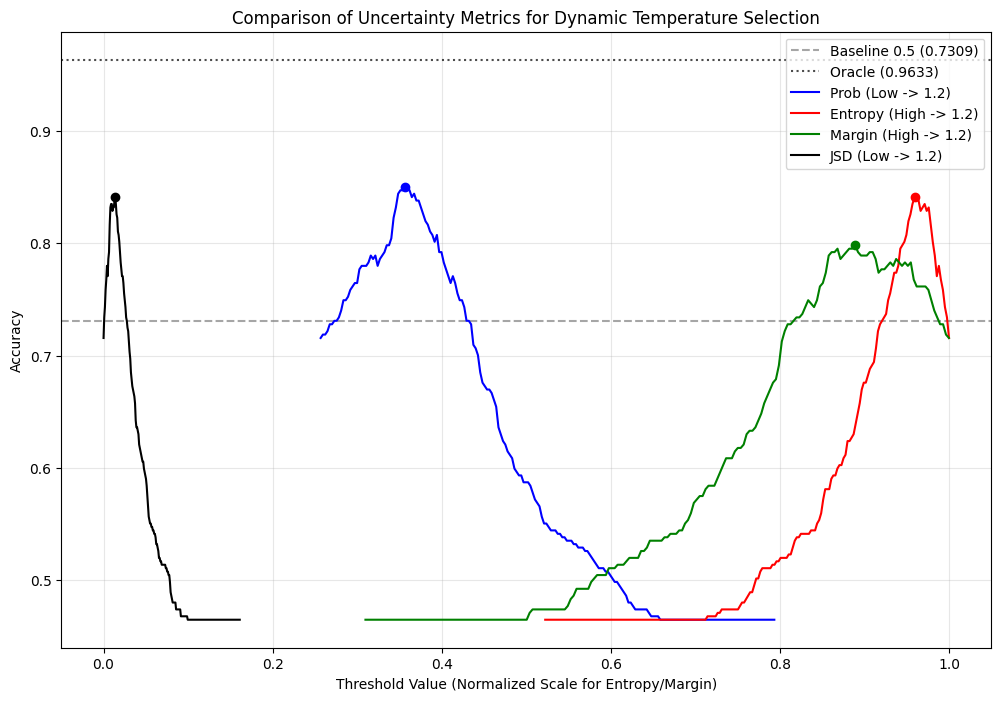

In [10]:
# 3. 각 지표별 분석 실행

# (1) Prob (Confidence): 값이 낮으면 불확실 -> 1.2 선택
best_acc_prob, th_prob, x_prob, y_prob = analyze_metric(df, 'uncertainty_prob', 'high_triggers_1.2')

# (2) Entropy: 값이 높으면 불확실 -> 1.2 선택
best_acc_ent, th_ent, x_ent, y_ent = analyze_metric(df, 'uncertainty_entropy', 'low_triggers_1.2')

# (3) Margin (1 - Gap): 값이 높으면 불확실 -> 1.2 선택
# (앞서 구현된 get_uncertainty에서 margin은 1 - (Top1-Top2)로 저장되었다고 가정)
best_acc_mar, th_mar, x_mar, y_mar = analyze_metric(df, 'uncertainty_margin', 'low_triggers_1.2')

# (4) JS Divergence
best_acc_js, th_js, x_js, y_js = analyze_metric(df, 'uncertainty_jsd', 'high_triggers_1.2')

print(f"\n=== Optimization Results ===")
print(f"[Prob] Best: {best_acc_prob:.4f} (Th: {th_prob:.4f}) | Gain: {(best_acc_prob - acc_10)*100:.2f}%p")
print(f"[Entropy] Best: {best_acc_ent:.4f} (Th: {th_ent:.4f}) | Gain: {(best_acc_ent - acc_10)*100:.2f}%p")
print(f"[Margin] Best: {best_acc_mar:.4f} (Th: {th_mar:.4f}) | Gain: {(best_acc_mar - acc_10)*100:.2f}%p")
print(f"[JSD] Best: {best_acc_js:.4f} (Th: {th_js:.4f}) | Gain: {(best_acc_js - acc_10)*100:.2f}%p")

# 4. 시각화 (통합 그래프)
plt.figure(figsize=(12, 8))

# Baseline & Oracle
plt.axhline(y=acc_10, color='gray', linestyle='--', label=f'Baseline 0.5 ({acc_10:.4f})', alpha=0.7)
plt.axhline(y=acc_oracle, color='black', linestyle=':', label=f'Oracle ({acc_oracle:.4f})', alpha=0.7)

# Metrics Plot
plt.plot(x_prob, y_prob, label='Prob (Low -> 1.2)', color='blue')
plt.plot(x_ent, y_ent, label='Entropy (High -> 1.2)', color='red')
plt.plot(x_mar, y_mar, label='Margin (High -> 1.2)', color='green')
plt.plot(x_js, y_js, label='JSD (Low -> 1.2)', color='black')

# Best Points
plt.scatter([th_prob], [best_acc_prob], color='blue', zorder=5)
plt.scatter([th_ent], [best_acc_ent], color='red', zorder=5)
plt.scatter([th_mar], [best_acc_mar], color='green', zorder=5)
plt.scatter([th_js], [best_acc_js], color='black', zorder=5)

plt.title('Comparison of Uncertainty Metrics for Dynamic Temperature Selection')
plt.xlabel('Threshold Value (Normalized Scale for Entropy/Margin)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()